1. Installing dependencies and setup 


In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This is an issue with the package mentioned above, not pip.
hint: See above for outpu

In [4]:
import tensorflow as tf 
import os 

In [5]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [6]:
#limiting the memory growth by setting up GPU memory consumption growth which helps avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus : 
  tf.config.experimental.set_memory_growth(gpu, True)

2. Remove dodgy images 

In [7]:
import cv2 
import imghdr
from matplotlib import pyplot as plt 

In [8]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Train Data/Normal/images_001/"

In [9]:
os.listdir(data_dir)

['Pnemonia', 'Nondiseased']

In [10]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [11]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try: 
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
          print("Image not in ext list {}".format(image_path))
          os.remove(image_path)
    except Exception as e:
      print("Issue with image{}".format(image_path)) 
    

3. Load Data 

In [12]:
import numpy as np 
from matplotlib import pyplot as plt 

In [13]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/Train Data/Normal/images_001')

#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that 
#yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 
#(0 corresponding to class_a and 1 corresponding to class_b).

Found 644 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [ ]:
#class 1 = Normal 
#Class 2 = Pnemonia 

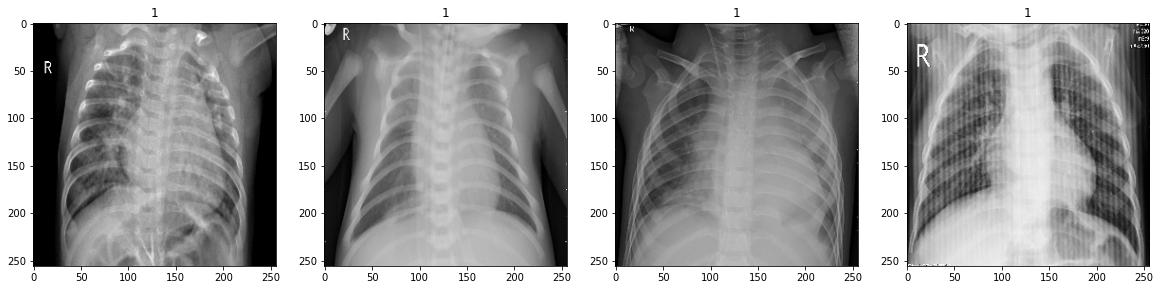

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

3. Scale the data 

In [17]:
data = data.map(lambda x,y: (x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

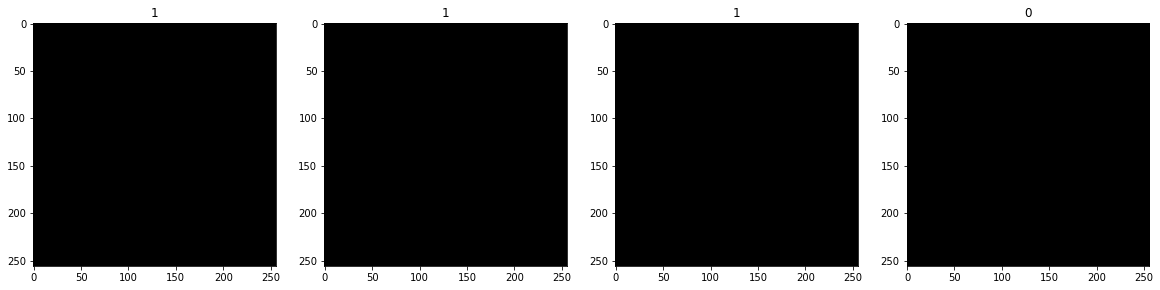

In [24]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

2.2 SPLIT DATA 

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [28]:
train_size * val_size * test_size

112

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size*val_size).take(test_size)

In [30]:
len(train)

14

3. DEEP LEARNING MODEL

In [31]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [36]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Train

In [39]:
logdir='logs'

In [40]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [41]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 21s 468ms/step - loss: 0.7181 - accuracy: 0.5960 - val_loss: 0.6397 - val_accuracy: 0.6016
Epoch 2/20
14/14 [==============================] - 6s 382ms/step - loss: 0.5194 - accuracy: 0.7567 - val_loss: 0.2823 - val_accuracy: 0.8828
Epoch 3/20
14/14 [==============================] - 7s 387ms/step - loss: 0.3166 - accuracy: 0.8683 - val_loss: 0.2479 - val_accuracy: 0.9219
Epoch 4/20
14/14 [==============================] - 8s 544ms/step - loss: 0.2739 - accuracy: 0.8862 - val_loss: 0.2903 - val_accuracy: 0.8750
Epoch 5/20
14/14 [==============================] - 6s 392ms/step - loss: 0.2325 - accuracy: 0.9062 - val_loss: 0.1829 - val_accuracy: 0.9375
Epoch 6/20
14/14 [==============================] - 7s 467ms/step - loss: 0.1849 - accuracy: 0.9196 - val_loss: 0.1507 - val_accuracy: 0.9609
Epoch 7/20
14/14 [==============================] - 8s 495ms/step - loss: 0.1468 - accuracy: 0.9330 - val_loss: 0.2159 - val_accuracy: 0.9141
Epoch

Plot performance 

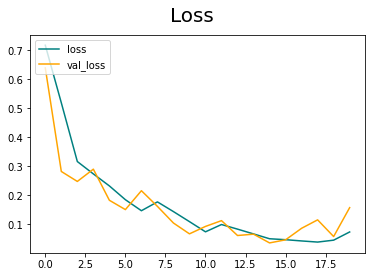

In [42]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

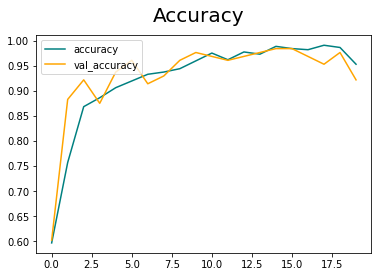

In [43]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate 

In [44]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [46]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [47]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


TEST

In [48]:
import cv2

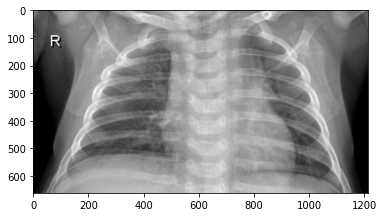

In [54]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Train Data/Normal/images_001/Nondiseased/NORMAL2-IM-0349-0001.jpeg')
plt.imshow(img)
plt.show()

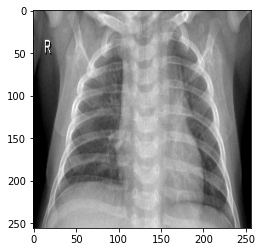

In [55]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
yhat = model.predict(np.expand_dims(resize/255, 0))


1/1 [==============================] - 0s 268ms/step


In [57]:
yhat

array([[0.01714434]], dtype=float32)

In [58]:
if yhat > 0.5: 
    print(f'''You may have a disease like pnemonia,
     Please go to a doctor for further checkup
       ''')
else:
    print(f'You are healthy!')

May have a disease like pnemonia, Please go to a doctor for further checkup 


Save the model 

In [59]:
from tensorflow.keras.models import load_model


In [60]:
model.save(os.path.join('models','imageclassifier.h5'))


In [ ]:
new_model = load_model('imageclassifier.h5')


In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))